# Leap-Forward ResNet

We conceive a different representations for ResNet.

In [5]:
import skimage.io
from classifier.layers import *
from data.image_util import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
data = load_tiny_imagenet('/Users/Aimingnie/Documents/School/Stanford/CS_231N/'
                          +'assignment3/cs231n/datasets/tiny-imagenet-100-A', sub_sample=0.1, subtract_mean=True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [3]:
# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  elif v == None:
    continue
  else:
    print k, type(v), len(v)

X_val <type 'numpy.ndarray'> (5000, 3, 64, 64) float32
class_names <type 'list'> 100
X_train <type 'numpy.ndarray'> (5000, 3, 64, 64) float32
y_train <type 'numpy.ndarray'> (5000,) int32
X_test <type 'numpy.ndarray'> (5000, 3, 64, 64) float32
y_val <type 'numpy.ndarray'> (5000,) int32
mean_image <type 'numpy.ndarray'> (3, 64, 64) float32


## Visualize Training Data

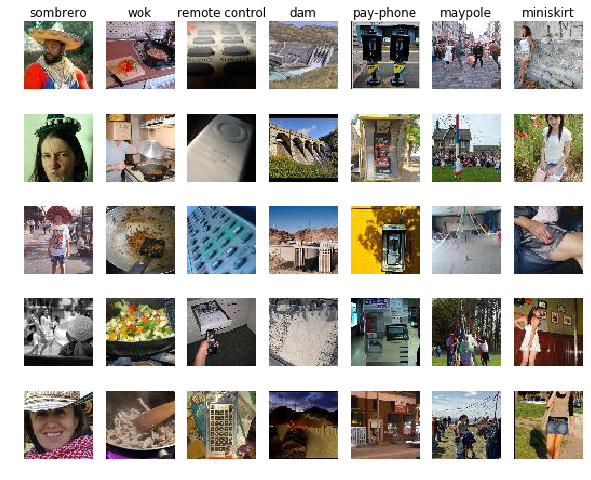

In [7]:
# Visualize some examples of the training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
  train_idxs, = np.nonzero(data['y_train'] == class_idx)
  train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
  for j, train_idx in enumerate(train_idxs):
    img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
    plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
    if j == 0:
      plt.title(data['class_names'][class_idx][0])
    plt.imshow(img)
    plt.gca().axis('off')

plt.show()

## Batch Normalization in Theano

We are testing if Batch Normalization works in Theano

In [33]:
from classifier.layers import *
from theano.tensor.nnet import bn
import numpy as np
import theano

N, D1, D2, D3 = 200, 50, 60, 3
X = np.asarray(np.random.randn(N, D1), dtype='float32')
W1 = np.asarray(np.random.randn(D1, D2), dtype='float32')
W2 = np.asarray(np.random.randn(D2, D3), dtype='float32')
a = np.maximum(0, X.dot(W1)).dot(W2)

print 'Before batch normalization:'
print '  means: ', a.mean(axis=0)
print '  stds: ', a.std(axis=0)

a_sym = T.matrix('a')
gamma = T.fvector('gamma')
beta = T.fvector('beta')

#mean = T.mean(a_sym, axis=0)
#std = T.var(a_sym, axis=0)

#exp = bn.batch_normalization(a_sym, gamma, beta, mean, std)
exp = batch_norm_layer(a_sym, gamma, beta, {'mode':'train'})

batchnorm_forward = theano.function([a_sym, gamma, beta], exp)

# Means should be close to zero and stds close to one
print 'After batch normalization (gamma=1, beta=0)'
a_norm = batchnorm_forward(a, np.ones(D3, dtype='float32'), np.zeros(D3, dtype='float32'))
print '  mean: ', a_norm.mean(axis=0)
print '  std: ', a_norm.std(axis=0)

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0], dtype='float32')
beta = np.asarray([11.0, 12.0, 13.0], dtype='float32')
a_norm = batchnorm_forward(a, gamma, beta)

print 'After batch normalization (nontrivial gamma, beta)'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

Before batch normalization:
  means:  [ 1.41730952  1.11035955  8.01801205]
  stds:  [ 35.93383789  32.16299057  36.48819733]
After batch normalization (gamma=1, beta=0)
  mean:  [  7.59959207e-09   5.36441824e-09  -1.19209287e-09]
  std:  [ 0.99999982  0.99999982  0.99999982]
After batch normalization (nontrivial gamma, beta)
  means:  [ 10.99999714  11.99999619  12.99999714]
  stds:  [ 0.99999988  1.99999964  3.00000024]


In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.asarray(np.random.randn(D1, D2), dtype='float32')
W2 = np.asarray(np.random.randn(D2, D3), dtype='float32')

bn_param = {'mode': 'train'}

a_sym = T.matrix('a')
gamma = T.fvector('gamma')
beta = T.fvector('beta')

exp = batch_norm_layer(a_sym, gamma, beta, bn_param)
batchnorm_forward = theano.function([a_sym, gamma, beta], exp)

for t in xrange(50):
  gamma = np.ones(D3)
  beta = np.zeros(D3)
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta)

bn_param['mode'] = 'test'
X = np.asarray(np.random.randn(N, D1), dypte='float32')
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After batch normalizatbatchnorm_forward = theano.function([a_sym, gamma, beta], exp)ion (test-time):'
print '  means: ', a_norm.mean(axis=0)
print '  stds: ', a_norm.std(axis=0)

## Spatial Batch Normalization in Theano

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print 'Before spatial batch normalization:'
print '  Shape: ', x.shape
print '  Means: ', x.mean(axis=(0, 2, 3))
print '  Stds: ', x.std(axis=(0, 2, 3))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print 'After spatial batch normalization:'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print 'After spatial batch normalization (nontrivial gamma, beta):'
print '  Shape: ', out.shape
print '  Means: ', out.mean(axis=(0, 2, 3))
print '  Stds: ', out.std(axis=(0, 2, 3))

In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in xrange(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print 'After spatial batch normalization (test-time):'
print '  means: ', a_norm.mean(axis=(0, 2, 3))
print '  stds: ', a_norm.std(axis=(0, 2, 3))

## Adding BatchNorm to CNN Net

Testing if CNN Net is capable of producing right amount of info from BatchNorm. And if the parameter outputs are correct

In [29]:
from classifier.layers import *
import numpy as np
import theano

net = ConvNet(input_dim=(3,32,32))
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 2)
net.initialize()

print net.layer_label
print
print net.layer_param

['conv_batch_relu', 'conv_batch', 'affine_softmax']

[{'conv_param': {'stride': 1, 'pad': 1}, 'relu_a': 100, 'bn_param': {'mode': 'train'}}, {'conv_param': {'stride': 1, 'pad': 1}, 'bn_param': {'mode': 'train'}}, {}]


In [32]:
from classifier.layers import *
import numpy as np
import theano

X = T.tensor4('X')  # data, presented as rasterized images
y = T.ivector('y')

X_train = np.asarray(np.random.randn(10,3,32,32), dtype='float32')
y_train = np.asarray([1,0,0,0,1,1,1,0,0,1], dtype='int32')

net = ConvNet(input_dim=(3,32,32))
net.add_conv_batch_relu_layer(16, 3, 1, 1, relu_a = 100)
net.add_conv_batch_layer(32, 3, 1, 1)
net.add_affine_softmax(net.prev_depth*net.affine_H*net.affine_W, 2)
net.initialize()

exp = net.loss(X, y)  # getting the loss expression

f = theano.function([], exp, givens={X: X_train, y: y_train})
f()

ValueError: Input dimension mis-match. (input[0].shape[3] = 16, input[1].shape[3] = 32)
Apply node that caused the error: Elemwise{Composite{(maximum(Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3), i4) + (i5 * Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3) * LT(Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3), i4)))}}[(0, 1)](InplaceDimShuffle{x,x,x,0}.0, Elemwise{Sub}[(0, 0)].0, Elemwise{Composite{sqrt((i0 + (i1 / i2)))}}[(0, 1)].0, InplaceDimShuffle{x,x,x,0}.0, TensorConstant{(1, 1, 1, 1) of 0.0}, TensorConstant{(1, 1, 1, 1) of 0.01})
Toposort index: 17
Inputs types: [TensorType(float32, (True, True, True, False)), TensorType(float32, 4D), TensorType(float32, (True, False, False, False)), TensorType(float32, (True, True, True, False)), TensorType(float32, (True, True, True, True)), TensorType(float32, (True, True, True, True))]
Inputs shapes: [(1, 1, 1, 16), (10, 16, 32, 32), (1, 16, 32, 32), (1, 1, 1, 16), (1, 1, 1, 1), (1, 1, 1, 1)]
Inputs strides: [(64, 64, 64, 4), (65536, 4096, 128, 4), (65536, 4096, 128, 4), (64, 64, 64, 4), (4, 4, 4, 4), (4, 4, 4, 4)]
Inputs values: ['not shown', 'not shown', 'not shown', 'not shown', array([[[[ 0.]]]], dtype=float32), array([[[[ 0.01]]]], dtype=float32)]
Outputs clients: [[Reshape{2}(Elemwise{Composite{(maximum(Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3), i4) + (i5 * Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3) * LT(Composite{((i0 * (i1 / i2)) + i3)}(i0, i1, i2, i3), i4)))}}[(0, 1)].0, MakeVector{dtype='int64'}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

## Running BatchNorm with Solver

# ResNet Architecture

## Vanilla ResNet Layer

This is the Vanilla ResNet layer. To keep things simple, downsampling isn't implemented.
We are also following the blueprint of http://torch.ch/blog/2016/02/04/resnets.html. Our ResNet block is No-ReLu, Batch Normalization before addition

![Res Net](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_modelvariants.png)


In [ ]:
from classifier.layers import *
import numpy as np
import theano



## Leap-Forward ResNet Layer

As stated in the original paper, projection instead of identity mapping could perform better. We consider a projection-based mapping amongst layers.

Regular ResNet shows a performance degradation when being used in a 1000-layer construct (shown in the paper), but Leap-Forward ResNet may be able to solve it.